REVISE with constraints

In [3]:
import pandas as pd
# Set display options to show all content within cells
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
# Set options to display everything in one line
pd.set_option('display.expand_frame_repr', False)

In [32]:
# the resulting df should have one line, with the averages of the grouped factuals
dataset_names = [
    'sepsis_cases_1', 'sepsis_cases_2', 'sepsis_cases_4', 
    'bpic2012_accepted', 
    'bpic2015_1_f2', 'bpic2015_2_f2','bpic2015_3_f2','bpic2015_4_f2', 'bpic2015_5_f2'
                 ]
def make_df(df):
    df = df[df['factual'] != df['counterfactual']].copy()
    grouped_df = df.groupby('factual') # Group by 'factual' column
    row_count = grouped_df.size().reset_index(name='row_count') # Calculate the number of CFs for each factual
    zero_violations_count = grouped_df.apply(lambda x: (x['Violations (%)'] == 0.0).sum()).reset_index(name='zero_violations_count') # Calculate the number of rows with 'Violations %' equal to 0.0 for each group
    result_df = pd.merge(row_count, zero_violations_count, on='factual') # Merge the results together based on the 'factual' column

    """we want to take the average values for the PLAUSIBLE CFS, 
    so we should group based on the counterfactuals with zero violations
    """
    if df[df['Violations (%)'] == 0.0].empty:
        plausible_cfs = df.copy()
        plausible_cfs[['y-NN', 'len CF', 'L1', 'L2', 'Linf', 'EMD', 'DL Edit', '# changes', 'LSP', 'diversity', 'Violations (%)']] = 0
    else:
        plausible_cfs = df[df['Violations (%)'] == 0.0].copy()
    grouped_plausible_df = plausible_cfs.groupby('factual') # Group by 'factual' column
    average_values = grouped_plausible_df.mean().round(2).reset_index() # Calculate the average for each remaining column for each group
    result_df = pd.merge(result_df, average_values, on='factual')

    if df[df['Violations (%)'] == 0.0].empty:
        result_df[['y-NN', 'len CF', 'L1', 'L2', 'Linf', 'EMD', 'DL Edit', '# changes', 'LSP', 'diversity', 'Violations (%)']] = 0
    #result_df = result_df.rename(columns={'Violations (%)': 'average_violations_percent'}) # Rename columns for clarity

    result_df['perc CFs'] = round(result_df['zero_violations_count']/result_df['row_count']*100, 2)
    
    result_df.rename(columns={'row_count': '$CFs$'}, inplace=True)
    result_df.rename(columns={'perc CFs': '$Plausible CFs$'}, inplace=True)

    result_df['succes rate'] = round(result_df['$CFs$']/15) # 1500 iterations, in percentage, so /15
    result_df['succes rate plausible'] = round(result_df['$Plausible CFs$']/15) # 1500 iterations, in percentage, so /15
    #print('the average CFS without violations per factual', result_df['zero_violations_count'].mean())
    #print('the average CFS per factual', result_df['row_count'].mean())
    mean_df_joint_result = result_df.mean()
    resulting_df = pd.DataFrame(columns = list(mean_df_joint_result.index))
    resulting_df.loc[0]  = mean_df_joint_result     # Add the Series as a new row
    return resulting_df

def make_resulting_df(dataset_name):

    # no constraints
    df_no = pd.read_csv('results/no_constraints/results_' + dataset_name + '_1500_no_constraints.csv')
    df_no_result = make_df(df_no)
    df_no_result['joint'] = 'REVISE'

    # joint and label-specific constraints
    df_joint = pd.read_csv('results/joint_constraints/results_' + dataset_name + '_1500_joint_constraints.csv')
    df_joint_result = make_df(df_joint)
    df_joint_result['joint'] = 'REVISED'
    
    # Concatenate the two DataFrames vertically
    merged_df = pd.concat([df_no_result, df_joint_result], axis = 0, ignore_index=False)
    merged_df['dataset name'] = [dataset_name, dataset_name]
    merged_df = merged_df[['joint', 'dataset name', '$CFs$', 'succes rate', 'succes rate plausible', '$Plausible CFs$', 'len CF','y-NN', 'L1', 'L2', 'EMD', 'DL Edit', '# changes', 'LSP', 'diversity' ]]
    #merged_df.index = merged_df['index']
    #merged_df = merged_df.drop(columns=['index'])
    merged_df = round(merged_df, 2)
    return merged_df

def concatenate_dfs(dataset_names):
    df_result = pd.DataFrame()
    for dataset_name in dataset_names:
        print('dataset:', dataset_name)
        dataset = make_resulting_df(dataset_name)
        df_result = pd.concat([df_result, dataset], axis=0, ignore_index=False)
    return df_result


In [33]:
# Concatenate the two DataFrames vertically
merged_df = concatenate_dfs(dataset_names)

averages_revise = merged_df[merged_df['joint'] == 'REVISE'].mean()
averages_revise = round(averages_revise, 2)
averages_revised = merged_df[merged_df['joint'] == 'REVISED'].mean()
averages_revised = round(averages_revised, 2)

revise_avg = ['REVISE', 'zavg.']
revise_avg.extend(averages_revise)
revised_avg = ['REVISED', 'zavg.']
revised_avg.extend(averages_revised)
merged_df.loc[len(merged_df)] = revise_avg
merged_df.loc[len(merged_df)] = revised_avg
merged_df = merged_df.sort_values(['joint', 'dataset name'], ascending=[True, True])

dataset: sepsis_cases_1
dataset: sepsis_cases_2
dataset: sepsis_cases_4
dataset: bpic2012_accepted
dataset: bpic2015_1_f2
dataset: bpic2015_2_f2
dataset: bpic2015_3_f2
dataset: bpic2015_4_f2
dataset: bpic2015_5_f2


In [34]:
merged_df

,joint,dataset name,$CFs$,succes rate,succes rate plausible,$Plausible CFs$,len CF,y-NN,L1,L2,EMD,DL Edit,# changes,LSP,diversity
0,REVISE,bpic2012_accepted,31.12,2.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
0,REVISE,bpic2015_1_f2,124.91,8.33,3.18,47.95,35.38,0.96,102.17,7.16,60.37,40.66,41.07,3.23,21.63
0,REVISE,bpic2015_2_f2,99.64,6.68,6.00,89.43,40.72,0.79,134.10,8.08,67.10,47.74,47.82,4.79,9.87
0,REVISE,bpic2015_3_f2,153.63,10.24,4.11,62.04,38.63,0.03,102.00,7.00,54.64,36.09,36.41,5.81,16.79
0,REVISE,bpic2015_4_f2,125.80,8.27,1.07,16.24,40.80,0.05,95.85,6.82,36.93,30.03,30.41,4.66,14.40
0,REVISE,bpic2015_5_f2,273.44,18.28,1.91,28.98,45.57,0.34,103.10,6.96,42.83,36.25,36.27,5.97,14.43
0,REVISE,sepsis_cases_1,17.00,1.14,4.14,61.23,20.40,0.79,39.24,4.49,1.69,11.31,11.57,6.00,0.88
0,REVISE,sepsis_cases_2,13.78,1.06,6.56,93.78,15.30,0.98,32.98,4.21,1.10,9.88,10.34,2.89,0.51
0,REVISE,sepsis_cases_4,8.91,0.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
18,REVISE,zavg.,94.25,6.28,3.00,44.41,26.31,0.44,67.72,4.97,29.41,23.55,23.77,3.71,8.72


In [35]:
merged_df.to_csv('results/merged_results.csv')

In [118]:
wandbdf = pd.read_csv("results\wandb_results.csv")
wandbdf = wandbdf[['proud-sweep-11 - validation_loss', 
                   'vivid-sweep-8 - validation_loss', 
                   'solar-sweep-5 - validation_loss']]

In [119]:

wandbdf.rename(columns={'proud-sweep-11 - validation_loss': '[100,50,3], 0.001'}, inplace=True)
wandbdf.rename(columns={'vivid-sweep-8 - validation_loss': '[100,10,3], 0.001'}, inplace=True)
wandbdf.rename(columns={'solar-sweep-5 - validation_loss': '[100,50,4], 0.001'}, inplace=True)
columns = ['[100,50,3], 0.001', '[100,10,3], 0.001', '[100,50,4], 0.001']

# Define colors and line thickness for each column
column_properties = {
    '[100,50,3], 0.001': {'color': 'red', 'linewidth': 4},
    '[100,10,3], 0.001': {'color': 'purple', 'linewidth': 4},
    '[100,50,4], 0.001': {'color': 'grey', 'linewidth': 4}
}


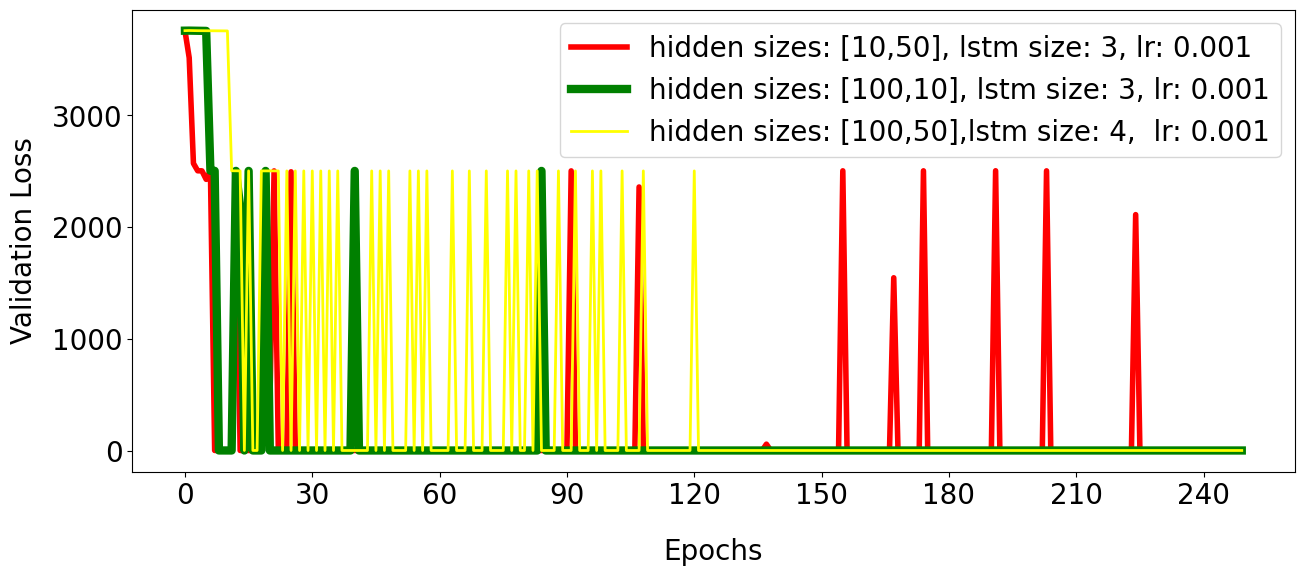

In [180]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import pandas as pd

# Assuming wandbdf is your DataFrame
columns = ['[100,50,3], 0.001', '[100,10,3], 0.001', '[100,50,4], 0.001']

# Define colors and line thickness for each column
column_properties = {
    'column1': {'color': 'red', 'linewidth': 4},
    'column2': {'color': 'green', 'linewidth': 6},
    'column3': {'color': 'yellow', 'linewidth': 2}
}

# Set the figure size based on the desired ratio
fig, ax = plt.subplots(figsize=(15, 6))

# Custom names for legend
custom_legend_names = ['hidden sizes: [10,50], lstm size: 3, lr: 0.001', 
                       'hidden sizes: [100,10], lstm size: 3, lr: 0.001', 
                       'hidden sizes: [100,50],lstm size: 4,  lr: 0.001']

# Plotting each line with different color and line thickness
for i, col in enumerate(columns):
    ax.plot(wandbdf.index, wandbdf[col], label=custom_legend_names[i], color=column_properties[f'column{i+1}']['color'], linewidth=column_properties[f'column{i+1}']['linewidth'])

# Adding legend with each line in a new row
ax.legend(ncol=1, loc='upper right')

# Set font size and font family
plt.rcParams.update({'font.size': 20, 'font.family': 'serif', 'font.serif': 'Computer Modern Roman'})

# Setting x-axis labels to integers
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# Move xlabel and ylabel above the figure
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()
ax.xaxis.set_label_position('bottom')
ax.yaxis.set_label_position('left')

# Adding labels and title
ax.set_xlabel('Epochs', fontsize=20, labelpad=20)
ax.set_ylabel('Validation Loss', fontsize=20, labelpad=10)

# Save the plot or display it
plt.savefig('results/wandb.pdf', bbox_inches='tight')  # Save as PDF for better quality
plt.show()